# Capstone Project - Data Exploration

_Author: Yifei Tong_

---
## Goal

The goal of this notebook is to perform an exploration of the collected data and get an initial understanding of the data set.
## Steps

1. Read collected data from a pickle file in the S3 bucket
2. Explore and plot data.

In [1]:
import pickle
import boto3
import sagemaker

In [2]:
session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket_name = session.default_bucket()
print(bucket_name)

sagemaker-us-east-2-989457217313


In [3]:
import os

dataset_prefix = 'financial-news-dataset'
pkl_file_name = 'news_dataset.pickle'
pkl_file_key = os.path.join(dataset_prefix, pkl_file_name)

s3_client = boto3.client('s3')
pickle_file = s3_client.get_object(Bucket=bucket_name, Key=os.path.join(dataset_prefix, pkl_file_name))['Body'].read()
dataset = pickle.loads(pickle_file)

In [24]:
google_X = [art['text'] for art in dataset['google']]
google_y = [art['percentage_change']*100 for art in dataset['google']]
amazon_X = [art['text'] for art in dataset['amazon']]
amazon_y = [art['percentage_change']*100 for art in dataset['amazon']]
facebook_X = [art['text'] for art in dataset['facebook']]
facebook_y = [art['percentage_change']*100 for art in dataset['facebook']]
microsoft_X = [art['text'] for art in dataset['microsoft']]
microsoft_y = [art['percentage_change']*100 for art in dataset['microsoft']]

In [14]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm

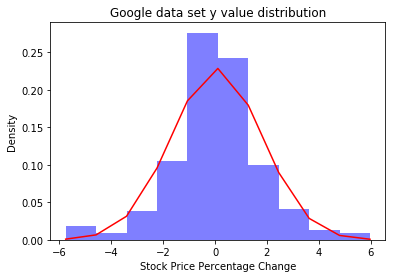

In [32]:
image_dir = '../image'
os.makedirs(image_dir, exist_ok=True)
num_bins = 10
google_n, google_bins, google_patches = plt.hist(google_y, num_bins, facecolor='blue', alpha=0.5, density=True)

google_mu = np.mean(google_y)
google_sigma = np.std(google_y)

google_norm = norm.pdf(google_bins, google_mu, google_sigma)
plt.plot(google_bins, y, 'r-')
plt.xlabel('Stock Price Percentage Change')
plt.ylabel('Density')
plt.title('Google data set y value distribution')
# plt.show()
plt.savefig(os.path.join(image_dir, 'google_y_dist.png'))

In the figure above, the blue bars represent the distribution of google stock price percentage changes on the news published dates collected in the data set. The red line represents a normal distribution with the same mean and standard deviation as the data set. We can see that the data is more centered and more thin-tailed than a normal distribution. With the stock price percentage change centered around 0, it is likely that we do not have enough difference in the data set to learn from. A well fitted algorithm may intend to predict more values close to 0, causing large errors when news article do cause large stock price movements.

Now we will plot the same values for the other three technology companies as well.

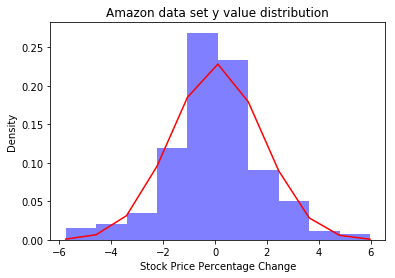

In [34]:
amazon_n, amazon_bins, amazon_patches = plt.hist(amazon_y, num_bins, facecolor='blue', alpha=0.5, density=True)

amazon_mu = np.mean(amazon_y)
amazon_sigma = np.std(amazon_y)

amazon_norm = norm.pdf(amazon_bins, amazon_mu, amazon_sigma)
plt.plot(amazon_bins, y, 'r-')
plt.xlabel('Stock Price Percentage Change')
plt.ylabel('Density')
plt.title('Amazon data set y value distribution')
plt.savefig(os.path.join(image_dir, 'amazon_y_dist.png'))

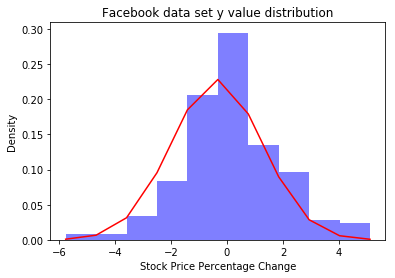

In [37]:
fb_n, fb_bins, fb_patches = plt.hist(facebook_y, num_bins, facecolor='blue', alpha=0.5, density=True)

fb_mu = np.mean(facebook_y)
fb_sigma = np.std(facebook_y)

fb_norm = norm.pdf(fb_bins, fb_mu, fb_sigma)
plt.plot(fb_bins, y, 'r-')
plt.xlabel('Stock Price Percentage Change')
plt.ylabel('Density')
plt.title('Facebook data set y value distribution')
plt.savefig(os.path.join(image_dir, 'fb_y_dist.png'))

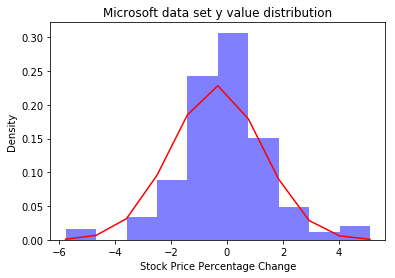

In [38]:
msft_n, msft_bins, msft_patches = plt.hist(microsoft_y, num_bins, facecolor='blue', alpha=0.5, density=True)

msft_mu = np.mean(microsoft_y)
msft_sigma = np.std(microsoft_y)

msft_norm = norm.pdf(msft_bins, msft_mu, msft_sigma)
plt.plot(msft_bins, y, 'r-')
plt.xlabel('Stock Price Percentage Change')
plt.ylabel('Density')
plt.title('Microsoft data set y value distribution')
plt.savefig(os.path.join(image_dir, 'msft_y_dist.png'))

In [39]:
# check if length of the news article correlates with the stock price change
google_lengths = [len(text) for text in google_X]
np.corrcoef(google_lengths, google_y)

array([[1.        , 0.01516217],
       [0.01516217, 1.        ]])

In [40]:
amazon_lengths = [len(text) for text in amazon_X]
np.corrcoef(amazon_lengths, amazon_y)

array([[ 1.        , -0.00282087],
       [-0.00282087,  1.        ]])

In [41]:
fb_lengths = [len(text) for text in facebook_X]
np.corrcoef(fb_lengths, facebook_y)

array([[ 1.       , -0.0171613],
       [-0.0171613,  1.       ]])

In [42]:
msft_lengths = [len(text) for text in microsoft_X]
np.corrcoef(msft_lengths, microsoft_y)

array([[1.        , 0.02301351],
       [0.02301351, 1.        ]])

From the above analysis of correlation coefficients, we can see no obvious linear relationship between the length of the articles and the stock price movement. Therefore, when modeling using linear regression, we do not have to include the length of the articles as a feature. This, however, does not indicate that the article lengths have no non-linear relationship with stock price change. In modeling using LSTM, I will still include the length of the articles as a feature to account for any possible non-linear relationship.

In [44]:
print('Google articles average length: {}'.format(np.mean([len(text.split()) for text in google_X])))
print('Amazon articles average length: {}'.format(np.mean([len(text.split()) for text in amazon_X])))
print('Facebook articles average length: {}'.format(np.mean([len(text.split()) for text in facebook_X])))
print('Microsoft articles average length: {}'.format(np.mean([len(text.split()) for text in microsoft_X])))

Google articles average length: 730.5516236469608
Amazon articles average length: 638.1706500956022
Facebook articles average length: 703.3311483783093
Microsoft articles average length: 736.2458193979933


The average length of the articles is around 700 words. Taking a pad length of 500 words should account for most of the important information in the articles.